[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/lisphilar/covid19-sir/HEAD?labpath=example%2F05_scenario_analysis.ipynb)

# Scenario analysis
We will perform scenario analysis. Regarding phase-dependent SIR-derived ODE models, this analysis focused on the impact of changes of ODE parameter values on the number of cases.

In [1]:
from datetime import timedelta
import pandas as pd
import covsirphy as cs
cs.__version__

'3.1.2.delta'

## 1. Create analyzer
An instance of `ODEScenario()` will be created here. We have two options as follows.

- With dataset of recommended servers
- With `pandas.DataFrame`
- With serialized ODEScenario object (JSON file, from version 2.28.0)

### 1.1 With dataset of recommended servers
We can create an instance with class method `ODEScenario.auto_build()` if the target dataset was registered in the recommended servers explained in [Data preparation]. As an example, we will use the dataset in Italy.

The following steps will be performed automatically and "Baseline" scenario will be registered.

Using `DataEngineer` class internally,

* Data downloading
* Data cleaning
* Data transformation
* Data subsetting
* Data complement (if necessary and selected)

Using `Dynamics` class internally,
* Time-series segmentation with S-R change point analysis
* Tau estimation
* ODE parameter estimation

In [2]:
snr_act = cs.ODEScenario.auto_build(geo="Italy", model=cs.SIRFModel, complement=True)

/app/covsirphy/dynamics/_trend.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_df[self.num2str(i)] = self._linear_f(phase_df[r], a=param[0], b=param[1])
/app/covsirphy/dynamics/_trend.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_df[self.num2str(i)] = self._linear_f(phase_df[r], a=param[0], b=param[1])
/app/covsirphy/dynamics/_trend.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colu

2025-12-14 at 15:00:42 | INFO | 
<SIR-F Model: parameter estimation>
2025-12-14 at 15:00:42 | INFO | Running optimization with 4 CPUs...


  0%|          | 0/124 [00:00<?, ?it/s]

2025-12-14 at 15:03:03 | INFO | Completed optimization. Total: 2 min 20 sec



We can perform simulation with `ODEScenario().simulate()` directly.

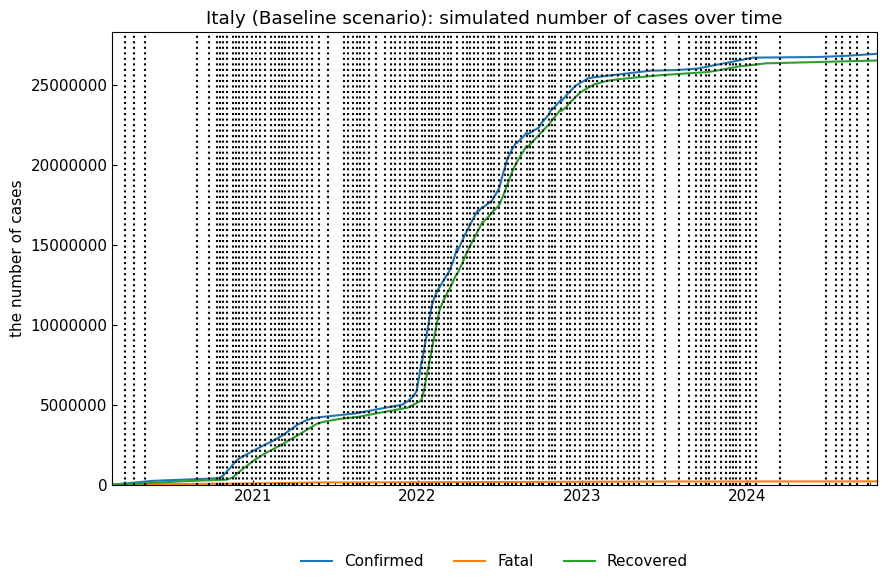

In [3]:
snr_act.simulate(name="Baseline");

Or, we can confirm the dynamics of the baseline scenario, producing `Dynamics` instance.

,Start,End,Rt,theta,kappa,rho,sigma,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day]
Phase,,,,,,,,,,,
0th,2020-02-24,2020-03-22,6.45,0.007763,0.001027,0.017907,0.001729,0.008,65,4,39
1st,2020-03-23,2020-04-10,2.65,0.025015,0.000634,0.004768,0.001118,0.025,105,14,60
2nd,2020-04-11,2020-05-05,1.1,0.021189,0.000257,0.001843,0.001376,0.021,260,36,48
3rd,2020-05-06,2020-08-28,0.33,0.009889,0.000099,0.000744,0.002118,0.01,672,90,31
4th,2020-08-29,2020-09-25,2.97,0.000051,0.000023,0.002849,0.000937,0.0,2953,23,71
...,...,...,...,...,...,...,...,...,...,...,...
119th,2024-07-18,2024-07-30,3.93,0.046395,0.000004,0.001651,0.000397,0.046,17075,40,168
120th,2024-07-31,2024-08-15,3.02,0.034883,0.000003,0.00146,0.000463,0.035,26351,46,144
121st,2024-08-16,2024-09-01,3.41,0.002498,0.000007,0.000995,0.000285,0.002,10209,67,234


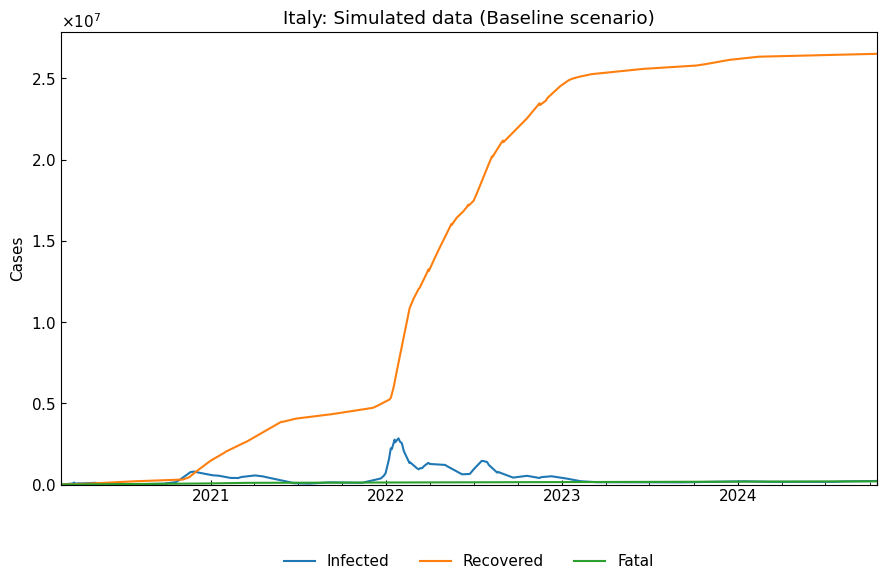

In [4]:
dyn_act = snr_act.to_dynamics(name="Baseline")
# Show summary
display(dyn_act.summary())
# Simulation
dyn_act_df = dyn_act.simulate(model_specific=False)
cs.line_plot(
    dyn_act_df.drop("Susceptible", axis=1), "Italy: Simulated data (Baseline scenario)")

If `name` is not specified, actual records will be shown.

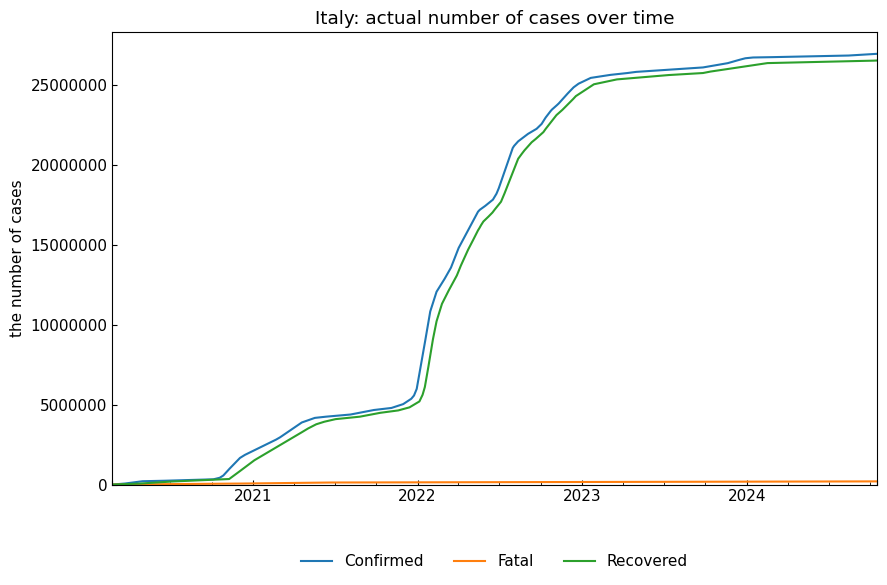

In [5]:
snr_act.simulate();

### 1.2 With `pandas.DataFrame`
The following solution is useful when we want to use `pandas.DataFrame` or sample data for scenario analysis.

At first, we will prepare an instance of `Dynamics`.

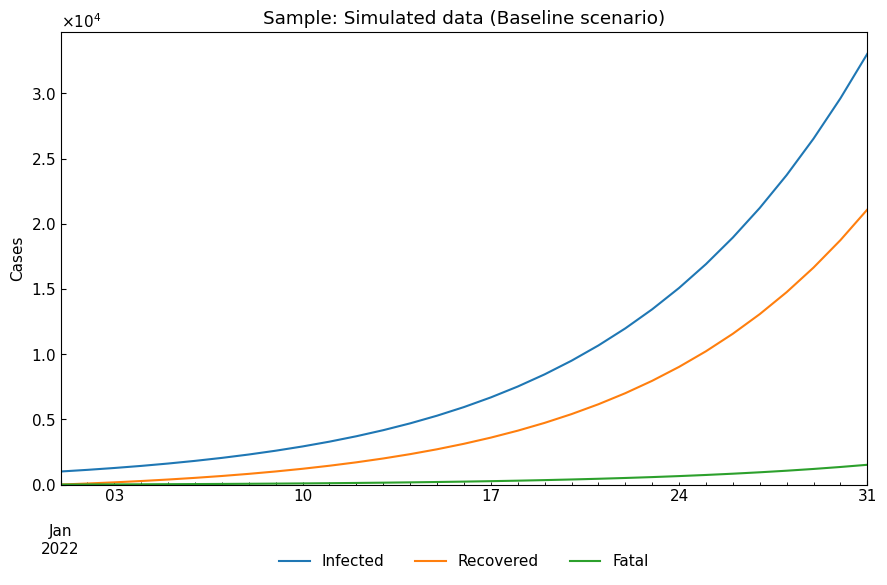

In [6]:
dyn_sample = cs.Dynamics.from_sample(cs.SIRFModel, date_range=("01Jan2022", "31Jan2022"), tau=1440)
sample_df = dyn_sample.simulate()
cs.line_plot(sample_df.drop("Susceptible", axis=1), "Sample: Simulated data (Baseline scenario)")

Then, prepare a `pandas.DataFrame` with time-index and Population/Confirmed/Recovered/Fatal columns. `DataEngineer` class will be useful.

In [7]:
eng = cs.DataEngineer(layers=["Country"])
df = sample_df.reset_index()
df.insert(0, "Country", "Sample")
eng.register(data=df)
eng.inverse_transform()
subset_df, *_ = eng.subset(
    geo="Sample", variables=["Population", "Confirmed", "Recovered", "Fatal"]
)
display(subset_df.head())
display(subset_df.tail())

,Population,Confirmed,Recovered,Fatal
Date,,,,
2022-01-01,1000000.0,1000,0,0
2022-01-02,1000001.0,1213,80,6
2022-01-03,1000000.0,1451,169,12
2022-01-04,999999.0,1720,271,19
2022-01-05,1000001.0,2025,385,28


,Population,Confirmed,Recovered,Fatal
Date,,,,
2022-01-27,1000000.0,35218,13068,940
2022-01-28,1000001.0,39544,14753,1061
2022-01-29,1000000.0,44357,16637,1196
2022-01-30,1000000.0,49704,18741,1347
2022-01-31,999999.0,55633,21088,1515


Finally, we can create an instance of `ODEScenario`.

In [8]:
snr = cs.ODEScenario(data=subset_df, location_name="Sample", complement=False)
snr.build_with_dynamics(name="Baseline", dynamics=dyn_sample)
# Show summary
snr.summary()

,,Start,End,Rt,theta,kappa,rho,sigma,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day],ODE,tau
Scenario,Phase,,,,,,,,,,,,,
Baseline,0th,2022-01-01,2022-01-31,2.5,0.002,0.005,0.2,0.075,0.002,200,5,13,SIR-F Model,1440


If we need to perform time-series segmentation, tau estimation and ODE parameter estimation, we can use `.build_with_model(name=<str>, model=<ODEModel>, data_range=<tuple of (str, str) or None>, tau=<int or None>` instead of `.build_with_dynamics()`.

### 1.3 With serialized `ODEScenario` object
From version 2.28.0, we can save scenario settings as JSON file using `ODEScenario.to_json(filename)`. The JSON file will be used to re-create `ODEScenario` object, skipping ODE parameter estimation step and so on.

To JSON file:

In [9]:
# Create {"filename": <absolute path>} easily
filer = cs.Filer(directory="input", prefix="jpn")
file_dict = filer.json(title="scenarios")
# To JSON file
json_file = snr.to_json(**file_dict)

From JSON file:

In [10]:
snr_recreated = cs.ODEScenario.from_json(json_file)
# Describe (explained later)
snr_recreated.describe()

,max(Infected),argmax(Infected),Confirmed on 31Jan2022,Infected on 31Jan2022,Fatal on 31Jan2022
Baseline,33030.0,2022-01-31,55633.0,33030.0,1515.0


## Set additional scenarios
We will define the following scenario as an example to analyze the impact of ODE parameter changes, copying the baseline scenario and add a phase with the changed ODE parameter values. Note that this is just an assumption. It will be better to change ODE parameter values for your analysis.

| name | 01Jan - 31Jan | $\kappa$ (to 30Jun) | $\rho$ (to 30Jun) | $\sigma$ (to 30Jun) |
|:---:|:---:|:---:|:---:|:---:|
| Baseline | 100% | 100% | 100% | 100% |
| Lockdown | 100% | 100% |  50% | 100% |
| Medicine | 100% |  50% | 100% | 200% |
| Vaccine  | 100% |  60% |  80% | 120% |

Get the baseline values of ODE parameters.

In [11]:
df = snr.summary()
kappa, rho, sigma = df.loc[("Baseline", "0th"), ["kappa", "rho", "sigma"]]
print(f"kappa={kappa:.4}, rho={rho:.4}, sigma={sigma:.4}")

kappa=0.005, rho=0.2, sigma=0.075


### 2.1 Lockdown scenario
This scenario assumes that $\rho$ value will be decreased from 01Feb2022 because of stay-home restriction.

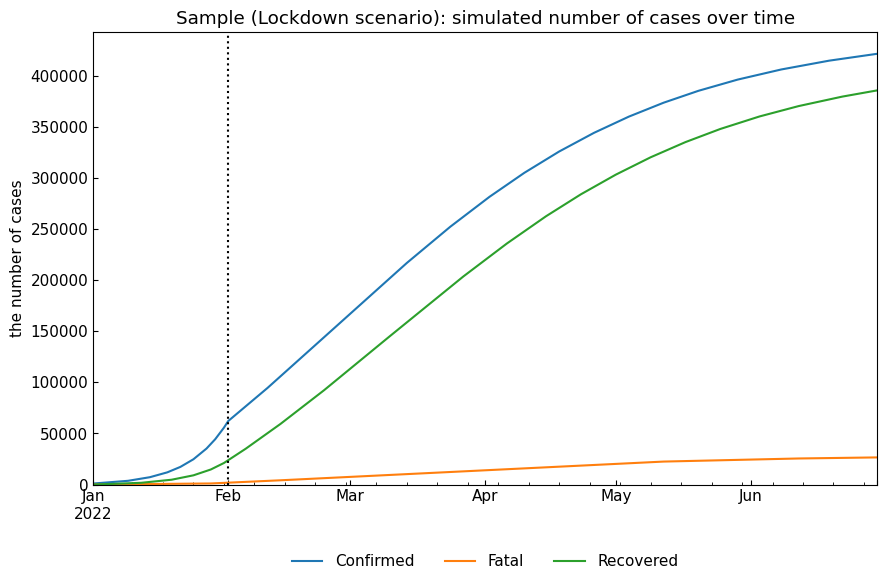

In [12]:
name = "Lockdown"
snr.build_with_template(name=name, template="Baseline")
snr.append(name=name, end="30Jun2022", rho=rho*0.5)
# Simulation
snr.simulate(name=name, v="01Feb2022");

### 2.2 Medicine scenario
This scenario assumes that $\kappa$ will be decreased and $\sigma$ will be increased because of new medicine development.

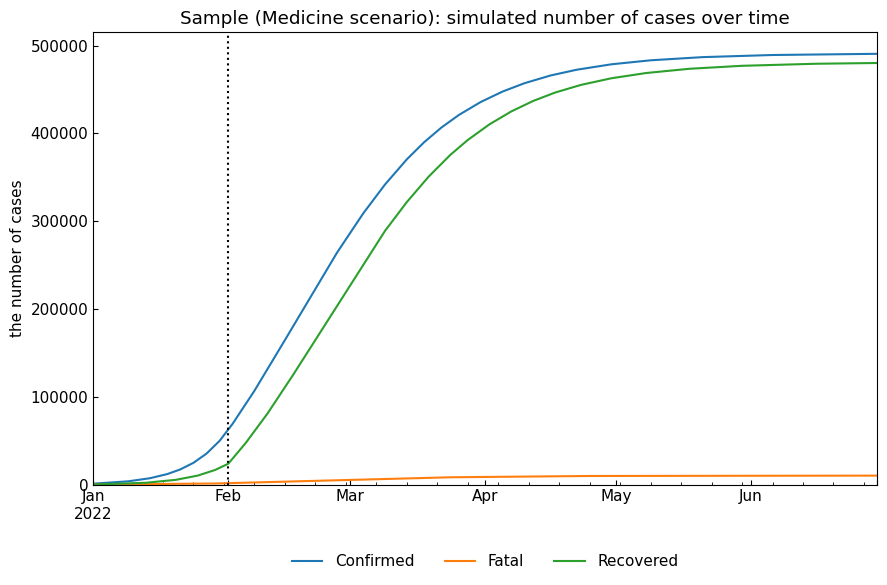

In [13]:
name = "Medicine"
snr.build_with_template(name=name, template="Baseline")
snr.append(name=name, end="30Jun2022", kappa=kappa*0.5, sigma=sigma*2)
# Simulation
snr.simulate(name=name, v="01Feb2022");

### 2.3 Vaccine scenario
This scenario assumes that $\kappa$ and $\rho$ will be decreased and $\sigma$ will be increased because of vaccination.

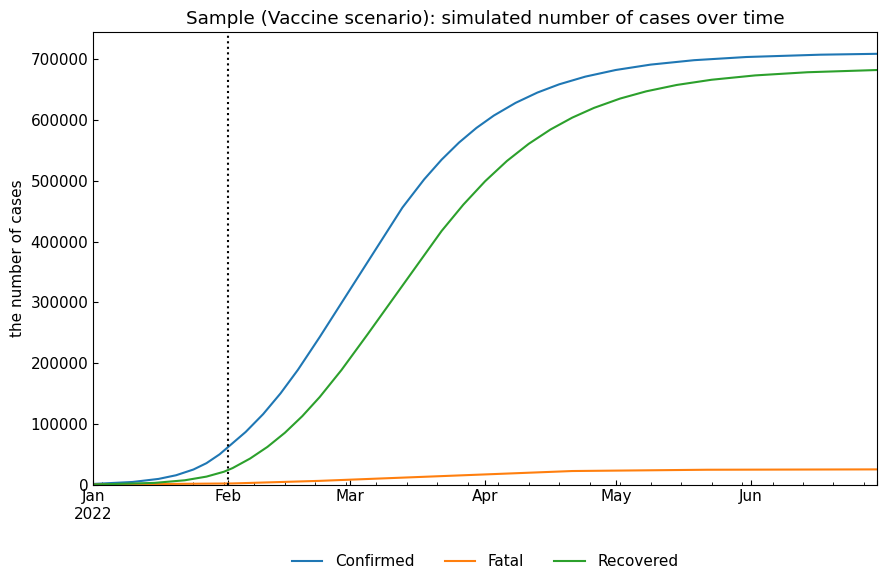

In [14]:
name = "Vaccine"
snr.build_with_template(name=name, template="Baseline")
snr.append(name=name, end="30Jun2022", kappa=kappa*0.6, rho=rho*0.8, sigma=sigma*1.2)
# Simulation
snr.simulate(name=name, v="01Feb2022");

### 2.4 Adjustment of the last dates
The last dates of the new scenarios are 30Jun2022, but the baseline scenario ends on 31Jan2022. We need to extend the last phase to the baseline scenario analysis with `ODEScenario().append(name="Baseline")` or `ODEScenario().append()` (useful when we have some unchanged scenarios).

Before appended:

In [15]:
snr.summary().style.applymap(lambda x: "background-color: yellow", subset=pd.IndexSlice[("Baseline", "0th"), "End"])

Append:

In [16]:
snr.append().summary().style.applymap(lambda x: "background-color: yellow", subset=pd.IndexSlice[("Baseline", "0th"), "End"])

If we need all values for dates, we can use `ODEScenario().track()` method.

In [17]:
snr.track()

,Scenario,Phase,Rt,theta,kappa,rho,sigma,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day],ODE,tau
Date,,,,,,,,,,,,,
2022-01-01,Baseline,0th,2.5,0.002,0.005,0.2,0.075,0.002,200,5,13,SIR-F Model,1440
2022-01-02,Baseline,0th,2.5,0.002,0.005,0.2,0.075,0.002,200,5,13,SIR-F Model,1440
2022-01-03,Baseline,0th,2.5,0.002,0.005,0.2,0.075,0.002,200,5,13,SIR-F Model,1440
2022-01-04,Baseline,0th,2.5,0.002,0.005,0.2,0.075,0.002,200,5,13,SIR-F Model,1440
2022-01-05,Baseline,0th,2.5,0.002,0.005,0.2,0.075,0.002,200,5,13,SIR-F Model,1440
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-26,Vaccine,1st,1.72,0.002,0.003,0.16,0.09,0.002,333,6,11,SIR-F Model,1440
2022-06-27,Vaccine,1st,1.72,0.002,0.003,0.16,0.09,0.002,333,6,11,SIR-F Model,1440
2022-06-28,Vaccine,1st,1.72,0.002,0.003,0.16,0.09,0.002,333,6,11,SIR-F Model,1440


## 3. Compare and evaluate scenarios

### 3.1 Compare the params
We will confirm the ODE parameter values and reproduction number with `ODEScenario().compare_param(param)` method.

Reproduction number:

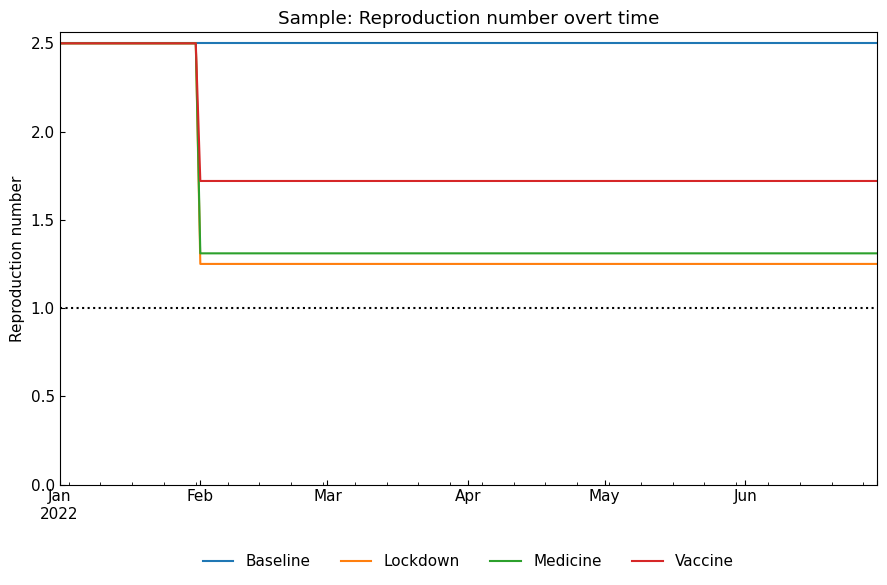

In [18]:
snr.compare_param("Rt");

ODE parameter values:

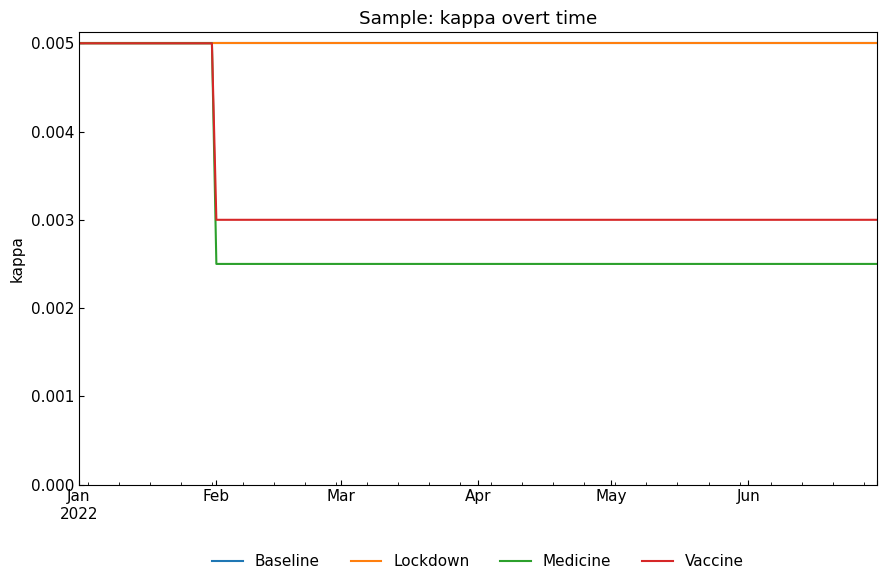

In [19]:
snr.compare_param("kappa");

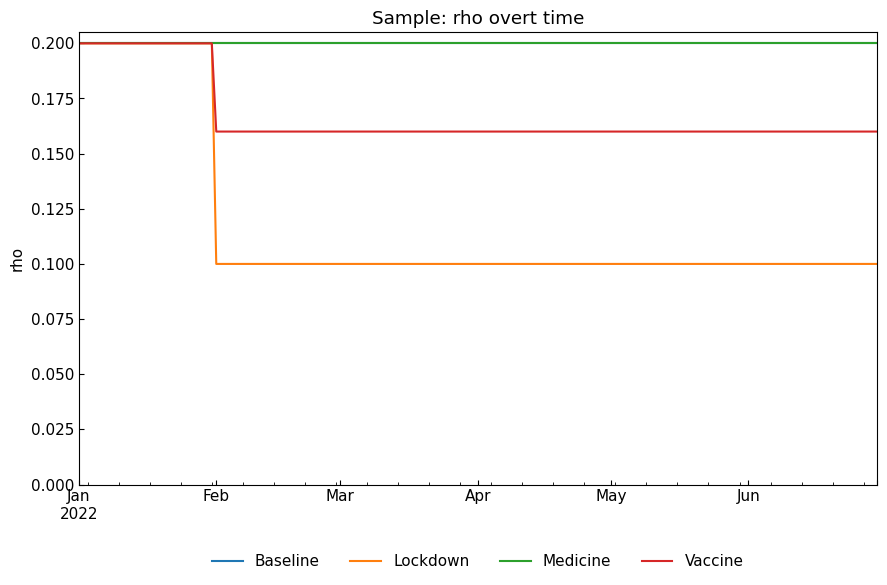

In [20]:
snr.compare_param("rho");

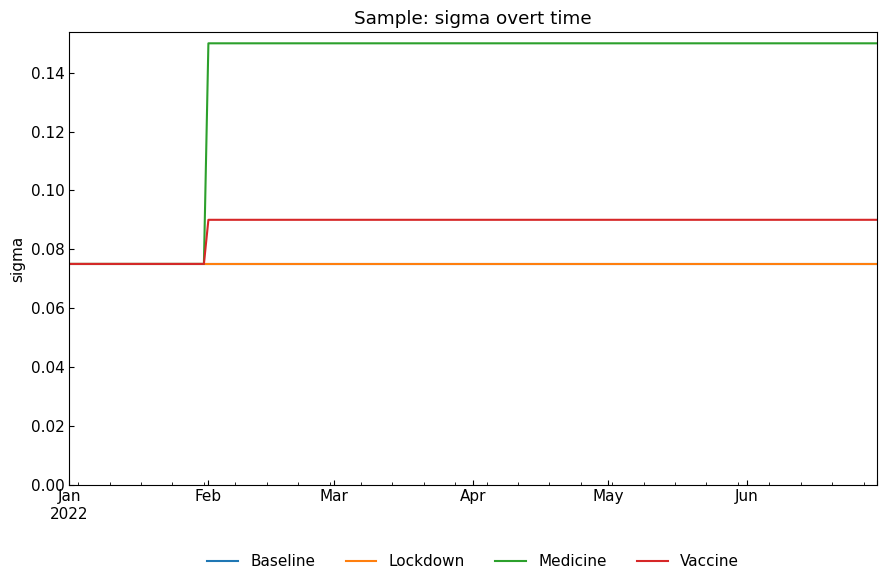

In [21]:
snr.compare_param("sigma");

### 3.2 Compare simulated number of cases
We will compare simulated number of cases with `ODEScenario().compare_cases(variable, date_range=<None or tuple of dates>)` method.

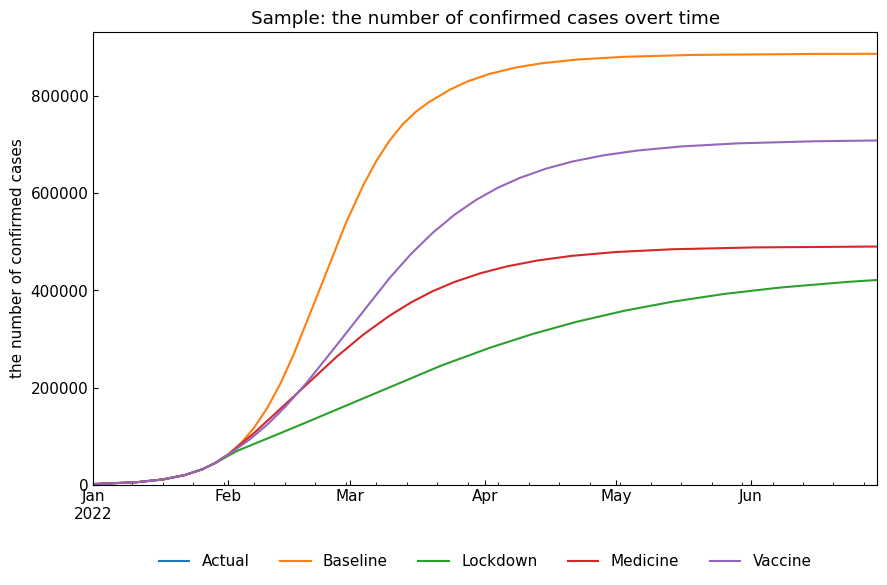

In [22]:
snr.compare_cases("Confirmed");

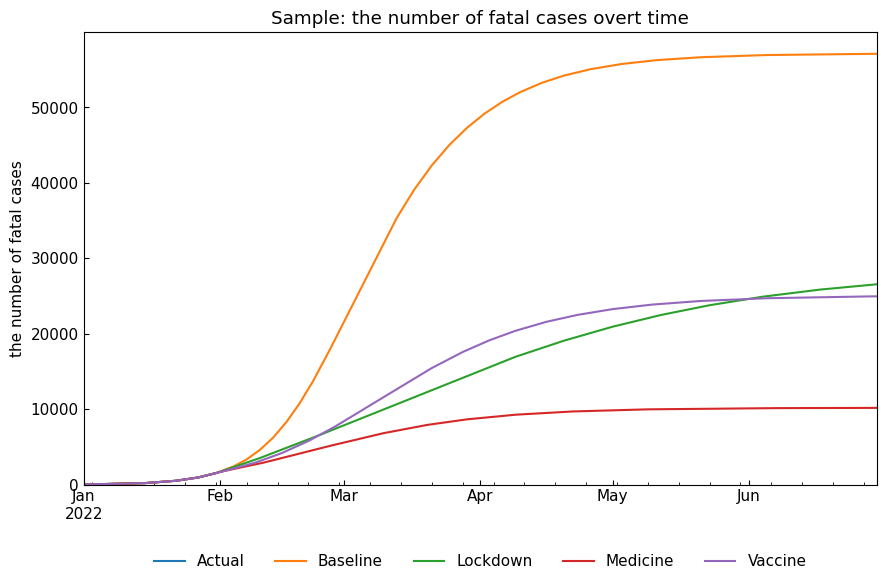

In [23]:
snr.compare_cases("Fatal");

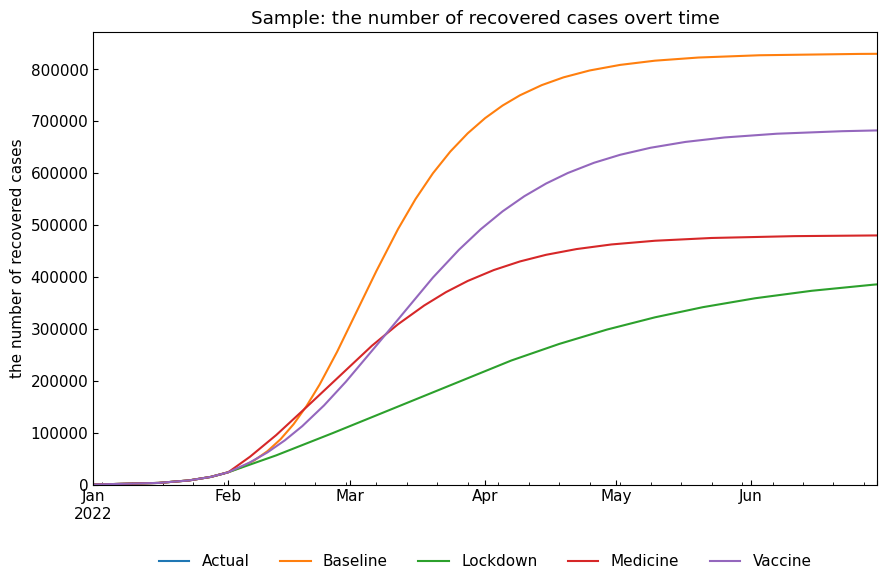

In [24]:
snr.compare_cases("Recovered");

### 3.3 Describe representative values
We can use `ODEScenario.describe()` to describe representative values of simulated number of cases. Max value of Infected and the number of cases on the last date will be shown as a `pandas.DataFrame`. This is useful to confirm the impact of OE parameter changes.

In [25]:
snr.describe()

,max(Infected),argmax(Infected),Confirmed on 30Jun2022,Infected on 30Jun2022,Fatal on 30Jun2022
Baseline,232733.0,2022-03-03,887821.0,574.0,57116.0
Lockdown,47075.0,2022-03-09,421595.0,9267.0,26559.0
Medicine,53834.0,2022-02-22,490556.0,284.0,10166.0
Vaccine,114876.0,2022-03-10,709162.0,1720.0,24956.0


### 3.4 Get representative scenario
Which scenario is the best/worst scenario? Specifying quantile, variable name and date, we can confirm that with `ODEScenario().represent(q=<float or tuple of float>, variable=<str>, date=<str or None>, included=<list of str or None>, excluded=<list of str or None>)`. `date=None` means the last date of scenarios.

In [26]:
scenarios = snr.represent(q=(0.1, 0.9), variable="Confirmed", excluded=["Baseline"])
print(f" the best: {scenarios[0]} (small number of confirmed cases)\nthe worst: {scenarios[1]} (large number of confirmed cases)")

 the best: Lockdown (small number of confirmed cases)
the worst: Vaccine (large number of confirmed cases)


We can rename a scenario with `ODEScenario().rename(old, new)`.

In [27]:
snr.rename(old=scenarios[0], new="Best")
snr.rename(old=scenarios[1], new="Worst").describe()

,max(Infected),argmax(Infected),Confirmed on 30Jun2022,Infected on 30Jun2022,Fatal on 30Jun2022
Baseline,232733.0,2022-03-03,887821.0,574.0,57116.0
Medicine,53834.0,2022-02-22,490556.0,284.0,10166.0
Best,47075.0,2022-03-09,421595.0,9267.0,26559.0
Worst,114876.0,2022-03-10,709162.0,1720.0,24956.0


We can delete a scenario with `ODEScenario().delete(pattern, exact=True)`. Just for demonstration, we will delete the scenario which is not the baseline/best/worst scenario.

In [28]:
deleted_scenarios = [name for name in snr.describe().index.unique() if name not in [*scenarios, "Best", "Worst", "Baseline"]]
deleted_scenarios

['Medicine']

In [29]:
for name in deleted_scenarios:
    snr.delete(name, exact=True)
snr.describe()

,max(Infected),argmax(Infected),Confirmed on 30Jun2022,Infected on 30Jun2022,Fatal on 30Jun2022
Baseline,232733.0,2022-03-03,887821.0,574.0,57116.0
Best,47075.0,2022-03-09,421595.0,9267.0,26559.0
Worst,114876.0,2022-03-10,709162.0,1720.0,24956.0


We can delete scenarios with regular expressions with `ODEScenario().delete(pattern, exact=True)`. Just for demonstration, we will add scenarios which names start with "Deleted_". Then, delete them.

In [30]:
snr.build_with_template(name="Deleted_1", template="Baseline")
snr.build_with_template(name="Deleted_2", template="Baseline").describe()

,max(Infected),argmax(Infected),Confirmed on 30Jun2022,Infected on 30Jun2022,Fatal on 30Jun2022
Baseline,232733.0,2022-03-03,887821.0,574.0,57116.0
Best,47075.0,2022-03-09,421595.0,9267.0,26559.0
Worst,114876.0,2022-03-10,709162.0,1720.0,24956.0
Deleted_1,232733.0,2022-03-03,887821.0,574.0,57116.0
Deleted_2,232733.0,2022-03-03,887821.0,574.0,57116.0


In [31]:
snr.delete("Deleted_", exact=False).describe()

,max(Infected),argmax(Infected),Confirmed on 30Jun2022,Infected on 30Jun2022,Fatal on 30Jun2022
Baseline,232733.0,2022-03-03,887821.0,574.0,57116.0
Best,47075.0,2022-03-09,421595.0,9267.0,26559.0
Worst,114876.0,2022-03-10,709162.0,1720.0,24956.0


As explained, we can compare the scenarios with the methods, `ODEScenario().compare_cases()` as an example.

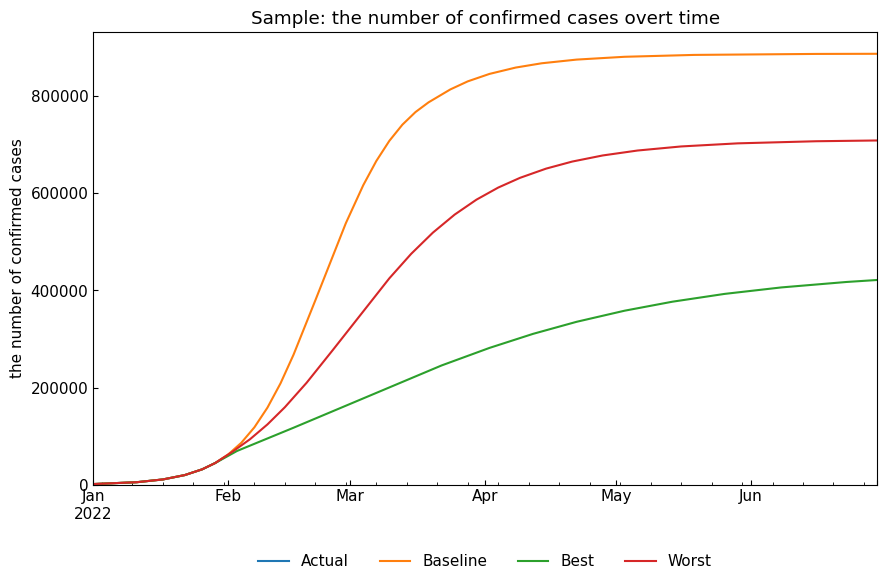

In [32]:
snr.compare_cases("Confirmed");

Thank you!